In [1]:
import tensorflow 
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import os
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
from collections import OrderedDict
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#dataset https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/DBW86T

In [3]:
df = pd.read_csv('../input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


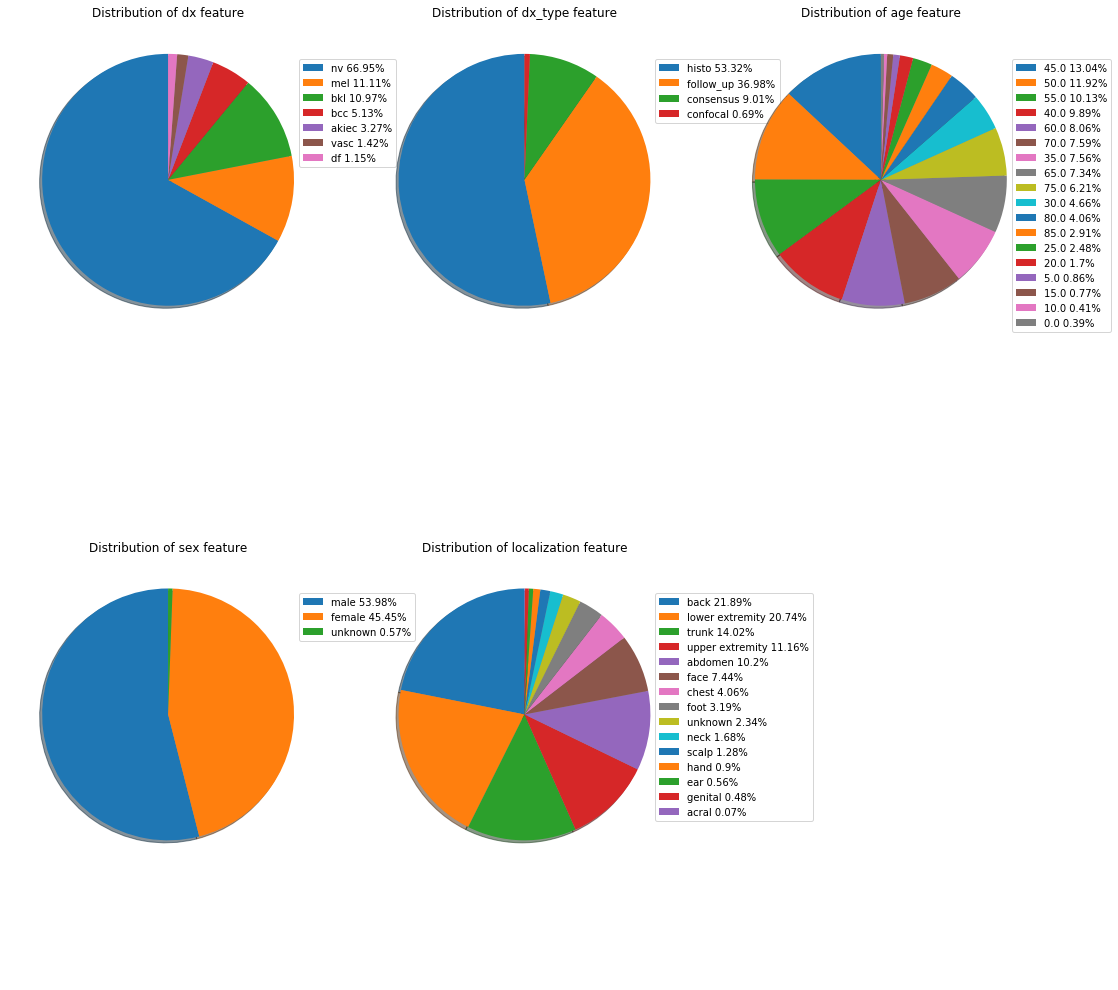

In [4]:
fig, axs = plt.subplots(2, 3, figsize=(15,15))
fig.tight_layout()
axs = axs.flatten()
for num, col in enumerate(df.columns[2:]):
    total =sum(list(df[col].value_counts()))
    ratio = [ str(round(x/total*100, 2)) for x in list(df[col].value_counts())]
    canc_labels = list(df[col].value_counts().index.astype('str'))
    labels = []
    for i in range(len(ratio)):
        labels.append(canc_labels[i] + ' ' + ratio[i] + '%')
    #sizes = list(df_data[col].value_counts())
    axs[num].pie(ratio,shadow=True, startangle=90)
    axs[num].legend(labels, loc='upper left', bbox_to_anchor=(0.9, 0.9))
    axs[num].set_title(f'Distribution of {col} feature')
axs[-1].axis('off');    

In [5]:
df_temp = df.groupby('lesion_id').count()
idxs = df['lesion_id'].isin(df_temp[df_temp['image_id'] == 1].index)
df_temp = df[idxs].reset_index(drop=True)
_, df_val = train_test_split(df_temp, test_size=1000, random_state=13, stratify=df_temp['dx'])
del df_temp

In [6]:
df_train = pd.concat([df,df_val]).drop_duplicates(keep=False)

In [7]:
base_dir = 'base_dir'
os.mkdir(base_dir)

train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)

lesion_list = ['nv', 'mel', 'bkl', 'bcc', 'akiec', 'vasc', 'df']
dir_list = [train_dir, val_dir]

for tr_val_dir in dir_list:
    for lesion in lesion_list:
        os.mkdir(os.path.join(tr_val_dir, lesion))

In [8]:
df.set_index('image_id', inplace=True)

In [9]:
folder_1 = os.listdir('../input/skin-cancer-mnist-ham10000/HAM10000_images_part_1')
folder_2 = os.listdir('../input/skin-cancer-mnist-ham10000/HAM10000_images_part_2')

img_tr_val_list = [[list(df_train['image_id']), train_dir], [list(df_val['image_id']), val_dir]]
for img_list in img_tr_val_list:
    for image in img_list[0]:
        fname = image + '.jpg'
        label = df.loc[image,'dx']

        if fname in folder_1:
            src = os.path.join('../input/skin-cancer-mnist-ham10000/HAM10000_images_part_1', fname)
            dst = os.path.join(img_list[1], label, fname)
            shutil.copyfile(src, dst)

        if fname in folder_2:
            src = os.path.join('../input/skin-cancer-mnist-ham10000/HAM10000_images_part_2', fname)
            dst = os.path.join(img_list[1], label, fname)
            shutil.copyfile(src, dst)

In [10]:
class_list = ['mel','bkl','bcc','akiec','vasc','df']

for item in class_list:
    aug_dir = 'aug_dir'
    os.mkdir('aug_dir')
    img_dir = os.path.join(aug_dir, 'img_dir')
    os.mkdir(img_dir)

    #img_class = item
    img_list = os.listdir('base_dir/train_dir/' + item)

    for fname in img_list:
            src = os.path.join('base_dir/train_dir/' + item, fname)
            dst = os.path.join(img_dir, fname)
            shutil.copyfile(src, dst)

    path = aug_dir
    save_path = 'base_dir/train_dir/' + item

    datagen = ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        #brightness_range=(0.9,1.1),
        fill_mode='nearest')

    batch_size = 64

    aug_datagen = datagen.flow_from_directory(path,
                                           save_to_dir=save_path,
                                           save_format='jpg',
                                                    target_size=(224,224),
                                                    batch_size=batch_size)
    
    num_aug_images_wanted = 6000 
    
    num_files = len(os.listdir(img_dir))
    num_batches = int(np.ceil((num_aug_images_wanted-num_files)/batch_size))

    for i in range(0,num_batches):
        imgs, labels = next(aug_datagen)
        
    shutil.rmtree('aug_dir')

Found 1071 images belonging to 1 classes.
Found 1019 images belonging to 1 classes.
Found 482 images belonging to 1 classes.
Found 300 images belonging to 1 classes.
Found 131 images belonging to 1 classes.
Found 108 images belonging to 1 classes.


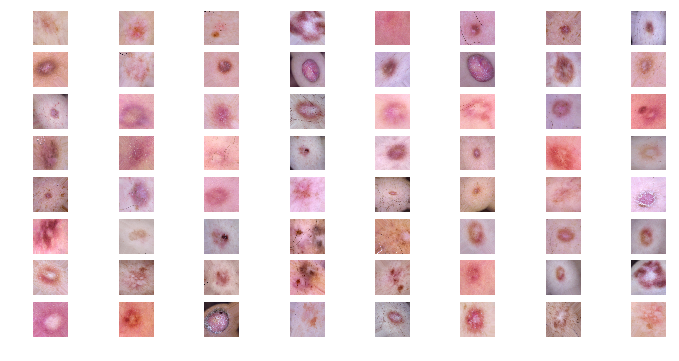

In [11]:
def plots(ims, figsize=(12,6), rows=8, interp=False, titles=None): 
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')
        
plots(imgs)

In [12]:
train_path = 'base_dir/train_dir'
valid_path = 'base_dir/val_dir'

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 10
val_batch_size = 10
image_size = 224

train_steps = num_train_samples // train_batch_size
val_steps = num_val_samples // val_batch_size

In [13]:
datagen = ImageDataGenerator(
    preprocessing_function= \
    tensorflow.keras.applications.mobilenet.preprocess_input)

train_batches = datagen.flow_from_directory(train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=train_batch_size)

valid_batches = datagen.flow_from_directory(valid_path,
                                            target_size=(image_size,image_size),
                                            batch_size=val_batch_size)

# Note: shuffle=False causes the test dataset to not be shuffled
test_batches = datagen.flow_from_directory(valid_path,
                                            target_size=(image_size,image_size),
                                            batch_size=1,
                                            shuffle=False)

Found 38669 images belonging to 7 classes.
Found 1000 images belonging to 7 classes.
Found 1000 images belonging to 7 classes.


In [14]:
mobile = tensorflow.keras.applications.mobilenet.MobileNet()

17227776/17225924 [==============================] - 1s 0us/step


In [15]:
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

In [16]:
x = mobile.layers[-6].output

x = Dropout(0.25)(x)
predictions = Dense(7, activation='softmax')(x)

model = Model(inputs=mobile.input, outputs=predictions)

In [17]:
for layer in model.layers[:-23]:
    layer.trainable = False

In [18]:
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

def top_2_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=2)

In [19]:
model.compile(Adam(lr=0.01), loss='categorical_crossentropy', 
              metrics=[categorical_accuracy, top_2_accuracy, top_3_accuracy])

In [20]:
print(valid_batches.class_indices)

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


In [21]:
class_weights={
    0: 1.0, # akiec
    1: 1.0, # bcc
    2: 1.0, # bkl
    3: 1.0, # df
    4: 3.0, # mel # Try to make the model more sensitive to Melanoma.
    5: 1.0, # nv
    6: 1.0, # vasc
}

In [22]:
filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_top_3_accuracy', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_top_3_accuracy', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
                              
callbacks_list = [checkpoint, reduce_lr]

history = model.fit_generator(train_batches, steps_per_epoch=train_steps, 
                              class_weight=class_weights,
                    validation_data=valid_batches,
                    validation_steps=val_steps,
                    epochs=30, verbose=1,
                   callbacks=callbacks_list)

Train for 901 steps, validate for 100 steps
Epoch 1/30
899/901 [============================>.] - ETA: 0s - loss: 1.7781 - categorical_accuracy: 0.5032 - top_2_accuracy: 0.7119 - top_3_accuracy: 0.8392
Epoch 00001: val_top_3_accuracy improved from -inf to 0.91800, saving model to model.h5
901/901 [==============================] - 62s 69ms/step - loss: 1.7752 - categorical_accuracy: 0.5041 - top_2_accuracy: 0.7124 - top_3_accuracy: 0.8395 - val_loss: 1.0024 - val_categorical_accuracy: 0.8000 - val_top_2_accuracy: 0.8680 - val_top_3_accuracy: 0.9180
Epoch 2/30
899/901 [============================>.] - ETA: 0s - loss: 1.2775 - categorical_accuracy: 0.6123 - top_2_accuracy: 0.8140 - top_3_accuracy: 0.9198
Epoch 00002: val_top_3_accuracy did not improve from 0.91800
901/901 [==============================] - 55s 61ms/step - loss: 1.2772 - categorical_accuracy: 0.6124 - top_2_accuracy: 0.8140 - top_3_accuracy: 0.9198 - val_loss: 2.2283 - val_categorical_accuracy: 0.4850 - val_top_2_accurac

In [23]:
val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc = \
model.evaluate_generator(test_batches, 
                        steps=len(df_val))

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)
print('val_top_2_acc:', val_top_2_acc)
print('val_top_3_acc:', val_top_3_acc)

val_loss: 1.0444919156195482
val_cat_acc: 0.77
val_top_2_acc: 0.907
val_top_3_acc: 0.956


In [24]:
model.load_weights('model.h5')

val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc = \
model.evaluate_generator(test_batches, 
                        steps=len(df_val))

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)
print('val_top_2_acc:', val_top_2_acc)
print('val_top_3_acc:', val_top_3_acc)

val_loss: 0.6924163071476723
val_cat_acc: 0.778
val_top_2_acc: 0.915
val_top_3_acc: 0.964


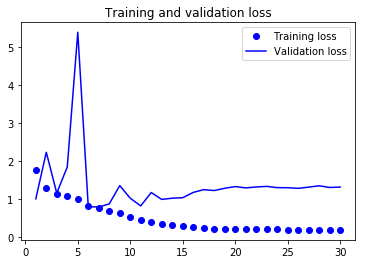

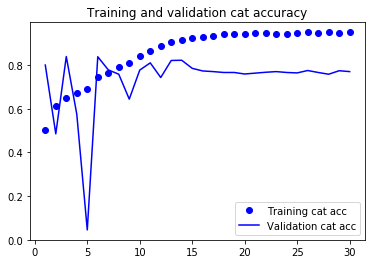

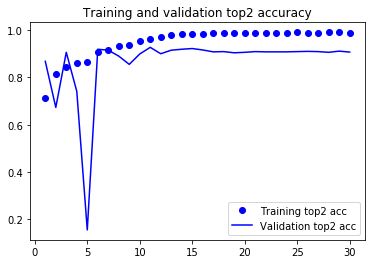

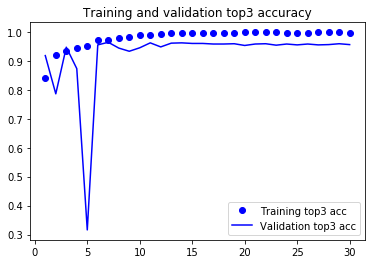

In [25]:
import matplotlib.pyplot as plt

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
train_top2_acc = history.history['top_2_accuracy']
val_top2_acc = history.history['val_top_2_accuracy']
train_top3_acc = history.history['top_3_accuracy']
val_top3_acc = history.history['val_top_3_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training cat acc')
plt.plot(epochs, val_acc, 'b', label='Validation cat acc')
plt.title('Training and validation cat accuracy')
plt.legend()
plt.figure()


plt.plot(epochs, train_top2_acc, 'bo', label='Training top2 acc')
plt.plot(epochs, val_top2_acc, 'b', label='Validation top2 acc')
plt.title('Training and validation top2 accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, train_top3_acc, 'bo', label='Training top3 acc')
plt.plot(epochs, val_top3_acc, 'b', label='Validation top3 acc')
plt.title('Training and validation top3 accuracy')
plt.legend()


plt.show()

In [26]:
test_labels = test_batches.classes

In [27]:
predictions = model.predict_generator(test_batches, steps=len(df_val), verbose=1)

1000/1000 [==============================] - 16s 16ms/step


In [28]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [29]:
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

Confusion matrix, without normalization
[[  2   6   1   4  14   0   0]
 [  0  28   0   1   3   0   0]
 [  5  12  15   6  30  12   0]
 [  0   1   1   4   0   1   0]
 [  1   2   2   5  27   5   0]
 [  0  27   2  19  57 696   0]
 [  0   1   0   0   2   2   6]]


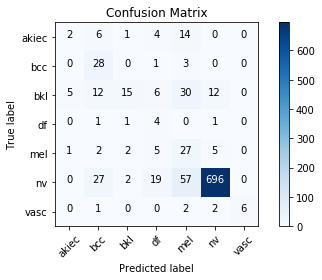

In [30]:
cm_plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel','nv', 'vasc']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

In [31]:
from sklearn.metrics import classification_report

report = classification_report(test_batches.classes, np.argmax(predictions, axis=1), target_names=cm_plot_labels)

print(report)

              precision    recall  f1-score   support

       akiec       0.25      0.07      0.11        27
         bcc       0.36      0.88      0.51        32
         bkl       0.71      0.19      0.30        80
          df       0.10      0.57      0.17         7
         mel       0.20      0.64      0.31        42
          nv       0.97      0.87      0.92       801
        vasc       1.00      0.55      0.71        11

    accuracy                           0.78      1000
   macro avg       0.52      0.54      0.43      1000
weighted avg       0.87      0.78      0.80      1000



In [32]:
pip install tensorflowjs

     |████████████████████████████████| 61kB 3.5MB/s 
     |████████████████████████████████| 104.6MB 140kB/s 
     |████████████████████████████████| 256kB 34.3MB/s 
  Created wheel for PyInquirer: filename=PyInquirer-1.0.3-cp36-none-any.whl size=32853 sha256=90c6dfebe5cfb169073aca0dc24a374aa6e22b222e9c17c5c961fb59a956115c
  Stored in directory: /root/.cache/pip/wheels/52/6c/b1/3e4b0e8daf42a92883c7641c0ea8ffb62e0490ebed2faa55ad
Successfully built PyInquirer
ERROR: jupyter-console 6.0.0 has requirement prompt_toolkit<2.1.0,>=2.0.0, but you'll have prompt-toolkit 1.0.14 which is incompatible.
ERROR: ipython 7.10.2 has requirement prompt-toolkit!=3.0.0,!=3.0.1,<3.1.0,>=2.0.0, but you'll have prompt-toolkit 1.0.14 which is incompatible.
  Found existing installation: prompt-toolkit 2.0.10
    Uninstalling prompt-toolkit-2.0.10:
      Successfully uninstalled prompt-toolkit-2.0.10
Note: you may need to restart the kernel to use updated packages.


In [33]:
os.mkdir('tfjs_dir')

import tensorflowjs as tfjs

tfjs.converters.save_keras_model(model, 'tfjs_dir')

In [34]:
shutil.rmtree('base_dir')